<a href="https://colab.research.google.com/github/jaime-garvey/web_personalization_portfolio/blob/master/notebooks/Website_Personalization_Markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing Google Analytics Data

# Imports

In [0]:
!pip install markovclick

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import dask

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import ast
import json

#Visualization
import matplotlib.pyplot as plt

#plt.style.use('seaborn-white')
#plt.style.use('fivethirtyeight')
%matplotlib inline

In [0]:
import sklearn as skl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk
from gensim import corpora

import markovclick
import seaborn as sns

In [0]:
pd.set_option('display.max_colwidth', -1)

## Import Data (Seperate Tables)

In [0]:
id = '1mGi2ZF8OKq4pSFcHU0IVpnXeBXSZTKOo'

### Flatten JSON Columns
(totals, trafficSource, device, geoNetwordk, customDimensions, hits)

In [0]:
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource', 'hits',
               'customDimensions']
  
other_cols = ['visitorId', 'visitNumber', 'visitStartTime','date','userId',
                'channelGrouping', 'socialEngagementType']
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
   
  #read the data file, convert the columns in the list of columns to parse using json loader,
  #convert the `fullVisitorId` field as a string
data_df = pd.read_csv('Filename.csv', converters={column: ast.literal_eval for column in cols_to_parse}, dtype={'fullVisitorId': 'str'})

### Get Hits DF

In [0]:

hits_df = pd.DataFrame(data_df['hits'])

In [0]:
### Helper function to get paths per session

def get_paths(mylist):
  path = []
  for element in mylist:
      try: 
        path.append(element['page']['pageTitle'])
      except:
        pass
  return path

In [0]:
hits_df['paths'] = hits_df.hits.apply(get_paths)

In [0]:
#list of unique pages
pages = list(set(hits_df.paths.sum()))

### Encode Paths

In [0]:
le = skl.preprocessing.LabelEncoder()

In [0]:
le.fit(pages)

LabelEncoder()

In [0]:
type(hits_df['paths'][0])

list

In [0]:
hits_df['paths_encoded']=hits_df['paths'].apply(lambda x: le.transform(x))

In [0]:
encoding_dict = dict(zip(le.transform(le.classes_),le.classes_))

In [0]:
paths_df = hits_df[['paths','paths_encoded']]

In [0]:
type(hits_df['paths_encoded'][0])

numpy.ndarray

In [0]:
paths_df

numpy.ndarray

In [0]:
paths_df['path_labels'] = paths_df.paths_encoded.apply(lambda x: x.astype('str').tolist())

In [0]:
def get_label(list):
  return ["P{}".format(word) for word in list]
  

In [0]:
paths_df['path_labels'] =paths_df['path_labels'].apply(get_label)

In [0]:
paths_df.path_labels[0]

['P88', 'P31', 'P118']

In [0]:
paths_df.head(1)

,paths,paths_encoded,pairs_encoded,path_labels
0,"[Home, Gift Cards, The Google Merchandise Store - Log In]","[88, 31, 118]","[(88, 31), (31, 118)]","[88, 31, 118]"


### Make Pairs (Bigrams)

In [0]:
def get_bigrams(mylist):
  bigrams = nltk.bigrams(mylist)
  return list(bigrams)
  

In [0]:
paths_df['pairs_encoded'] = paths_df.path_labels.apply(get_bigrams)

In [0]:
paths_df.head(1)

,paths,paths_encoded,pairs_encoded,path_labels
0,"[Home, Gift Cards, The Google Merchandise Store - Log In]","[88, 31, 118]","[(88, 31), (31, 118)]","[88, 31, 118]"


In [0]:
pairs_bigrams = paths_df.pairs_encoded.sum()

In [0]:
pairs = pd.DataFrame(pairs_bigrams, columns=['state1', 'state2'])
counts = pairs.groupby('state1')['state2'].value_counts()
probs = (counts / counts.sum()).unstack()

# Markov

In [0]:
from markovclick.models import MarkovClickstream

In [0]:
paths_clickstreams = paths_df.path_labels.tolist()

In [0]:
m = MarkovClickstream(paths_clickstreams)

In [0]:
from markovclick.viz import visualise_markov_chain
graph = visualise_markov_chain(m)

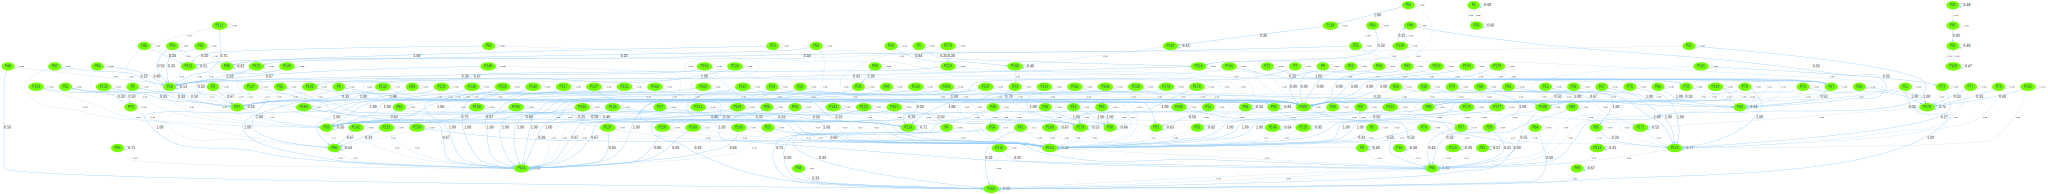

In [0]:
graph

In [0]:
transitions_dict = {}

def learn_key(key, value):
  if key not in transitions_dict:
    transitions_dict[key] = []

  transitions_dict[key].append(value)

In [0]:
def get_transition_dict(bigram_list):
  for bigram in bigram_list:
    key, value = bigram
    learn_key(key, value)

In [0]:
get_transition_dict(pairs_bigrams)

# Markov

In [0]:
from markovclick import dummy

In [0]:
clickstream = dummy.gen_random_clickstream(n_of_streams=100, n_of_pages=12)

In [0]:
clickstream

[['P5', 'P9', 'P6', 'P3', 'P7', 'P7', 'P10', 'P6', 'P7', 'P5'],
 ['P10', 'P9', 'P6', 'P4', 'P6', 'P11', 'P3', 'P0'],
 ['P0', 'P9', 'P1', 'P5', 'P3', 'P9', 'P2', 'P3', 'P3'],
 ['P4', 'P5', 'P11', 'P0', 'P3', 'P11', 'P6', 'P5', 'P2'],
 ['P2', 'P7', 'P2', 'P10', 'P9', 'P4', 'P1', 'P6', 'P6', 'P8', 'P8'],
 ['P10', 'P6', 'P8', 'P6', 'P6', 'P8', 'P5', 'P5'],
 ['P7', 'P8', 'P5', 'P4', 'P1', 'P7', 'P5', 'P9', 'P1', 'P7'],
 ['P7', 'P1', 'P4', 'P1', 'P7', 'P1', 'P10', 'P3'],
 ['P9', 'P3', 'P10', 'P0', 'P7', 'P7', 'P0', 'P10', 'P10', 'P10', 'P0'],
 ['P0', 'P9', 'P7', 'P10', 'P1', 'P6', 'P9', 'P10'],
 ['P4', 'P8', 'P3', 'P6', 'P3', 'P6', 'P7', 'P5', 'P1'],
 ['P11', 'P3', 'P5', 'P5', 'P9', 'P4', 'P11', 'P11', 'P10'],
 ['P9', 'P2', 'P10', 'P7', 'P1', 'P4', 'P4', 'P0', 'P7', 'P7', 'P6'],
 ['P10', 'P4', 'P2', 'P4', 'P3', 'P5', 'P8', 'P1', 'P8'],
 ['P9', 'P10', 'P1', 'P6', 'P6', 'P6', 'P6', 'P9', 'P7', 'P8', 'P4'],
 ['P9', 'P3', 'P4', 'P2', 'P2', 'P2', 'P5', 'P6', 'P8', 'P7'],
 ['P9', 'P4', 'P7', 'P10'

In [0]:
from markovclick.models import MarkovClickstream

In [0]:
m = MarkovClickstream(clickstream)

In [0]:
m.pages

['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11']

# Preprocessing

### Feature Descriptions

| Feature      | Description |
|-------------------|--------------------|
|channelGrouping |The channel via which the user came to the Store. |
|date | The date on which the user visited the Store.|
|device |The specifications for the device used to access the Store.|
|fullVisitorId| A unique identifier for each user of the Google Merchandise Store.|
|geoNetwork|This section contains information about the geography of the user.|
|sessionId | A unique identifier for this visit to the store.|
|socialEngagementType | Engagement type, either "Socially Engaged" or "Not Socially Engaged".|
|totals |This section contains aggregate values across the session.|
|trafficSource |This section contains information about the Traffic Source from which the session originated.|
|visitId | An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.|
|visitNumber |The session number for this user. If this is the first session, then this is set to 1.|
|visitStartTime -|The timestamp (expressed as POSIX time).|

### Converting to Datetime

In [0]:
##Helper function to make datetime objects

def get_datetime(visitors_df):
  #Convert date column to datetime object
  visitors_df['date'] = pd.to_datetime(visitors_df['date'])
  
  #Convert visitStartTime to datetime
  visitors_df['visitStartTime'] = pd.to_datetime(visitors_df['visitStartTime'], unit='s')
  
  return visitors_df


In [0]:
visitors = get_datetime(visitors)

# EDA

In [0]:
features.keys()

dict_keys(['device', 'geoNetwork', 'totals', 'trafficSource', 'hits', 'customDimensions'])

In [0]:
features['hits'][4][0]['page']['pageTitle']

TypeError: ignored

In [0]:
path_1 = []

for col in range(0, 230):
  try: 
    path_1.append(features['hits'][col][0]['page']['pageTitle'])
  except:
    pass

In [0]:
len(features['hits'])

1711

In [0]:

def get_paths():
  session_paths = {}
  for session in range(len(features['hits'])):
    path = []
    for col in range(0, 230):
      try: 
        path.append(features['hits'][col][session]['page']['pageTitle'])
      except:
        pass
    session_paths[session] = path
  return session_paths